# 【讃岐うどん検査】
## 人間が識別で迷う物をディープラーニングのCNNで識別を行う

- 今回識別を行うのは本場讃岐うどんと、それ以外のうどんの2つの分類を行う
- 讃岐である確率○○％、その他のうどん○○％の表示を行う
- 最後に讃岐風のうどんチェーン店のうどんを識別する、本場の讃岐うどんか、その他のうどんか識別してもらう
- testデータでどれだけ高い割合の%が出来るか検証してみる

### ■使用データ
- 学習用データはスクレイピンで取得した、500枚の本場讃岐うどんと、500枚のその他うどん

- testデータは個人的に撮影した画像(1枚は友人からもらった、本場讃岐うどん含む)

## ■仮説
- 讃岐特有の麺の特徴などはあるが、器やうどんの具材は讃岐うどんにもばらつきがあるので、40%〜70%の割合で、あまりはっきり答えがないかもしれない

## 使用外部ライブラリ

- Pillow==7.0.0
- numpy==1.18.1

- glob2==0.7
- numpy==1.18.1
- scikit-learn==0.22.1
- tensorflow==2.2.0
- Keras==2.4.2
- matplotlib==3.1.3

## ■学習データの作成
- 使用する外部モジュールをインポートする
- globで学習用データのファイルのパス名を取得

In [70]:
from PIL import Image
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras import Sequential
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

image_path = "sanuki/*"
image_path2 = "anotherudon/*"


files = glob.glob(image_path)
files2 = glob.glob(image_path2)

## 　■画像データの加工

- 一つ一つの画像を、読み込みを行う、
- 100×100のサイズにして、色があった方が、特徴をつかみやすくなるかもしれないのでRGBの３を設定を行う、
- numpyデータに変換して、讃岐とその他のうどんのリストにそれぞれ追加する
- リストを統合する、前半500のデータは讃岐うどん、後半500はその他のうどんとして学習データにする
- リストを学習データのx_trainとする(合計1000枚の画像で100×100,でRGB(3)とする)

In [71]:
sanuki = []  
another = []

for i,f in enumerate (files):
  img = Image.open(f)
  resized_image = img.convert("RGB").resize((100,100))
  im = np.array(resized_image)
  sanuki.append(im)

for n,t in enumerate(files2,500):
  img2 = Image.open(t)
  resized_image_2 = img2.convert("RGB").resize((100,100))
  im2 = np.array(resized_image_2)
  another.append(im2)


sanuki.extend(another)
x_train = np.array(sanuki)
x_train.shape

(1000, 100, 100, 3)

## ■ラベルデータの作成

- 讃岐うどんのラベル0を×500、その他のうどん1×500の数値を作成して、ラベルデータを作成する

In [72]:
honba = [0]*500
another_udon = [1]*500

honba.extend(another_udon)
y_train = np.array(honba)
y_train = y_train.astype("uint8")

## ■検証用データの作成
- 学習用データ、ラベルデータから検証用データを作成
- 検証用データは全体の3割にする

In [73]:
x_train1, x_valid, y_train1, y_valid = train_test_split(x_train, y_train, test_size=0.3, random_state=6)

## ■model作成

- Sequentialでcnnのmodelを作成
- 活性化関数はディープラーニングの隠れ層に精度が良い、reluを使うが、最後の層は２分類に適してるsigmoidを使う
- 出来るだけ、過学習を起こさないため、最後のDropoutは0.5で設定する

|  作成する層 | 説明|
| ---- | |
|  2次元の畳み込み層 |3×3のフィルターを64回かけ特徴を抽出する |
|  2次元の畳み込み層 | 3×3のフィルターを128回かけ特徴を抽出する|
|  MaxPooling層 |入力画像内の「2×2」の領域で最大の数値を出力 |
|  ドロップアウト層|0.25のユニットを無効化にして、化学習を防ぐ |
| 　平坦化 |1次現ベクトルに変換 |
|  全結合層128| 出力層を128に変換|
|  ドロップアウト層| 0.5のユニットを無効化にして、化学習を防ぐ |
|  出力層softmax| ユニット数２で出力|

In [74]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

## ■学習データ、検証用データの加工

- 学習用データは計算しやすいように、255で割り、少数にする
- ラベルデータは0(讃岐うどん) または1（その他のうどん）かの枠を作成

In [75]:
import keras
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_train /= 255
x_valid /= 255


y_valid2 = y_valid
y_train = keras.utils.to_categorical(y_train, 2)
y_valid = keras.utils.to_categorical(y_valid, 2)

## ■学習を開始
- 学習は13回行い、１回に処理を行うバッチサイズは128とする
- verboseで学習の進捗を表示する

In [76]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])


history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=12,
                    verbose=1,
                    validation_data=(x_valid, y_valid))

Epoch 1/12
8/8 [==============================] - 23s 3s/step - loss: 2.4393 - accuracy: 0.5020 - val_loss: 0.7015 - val_accuracy: 0.5167
Epoch 2/12
8/8 [==============================] - 24s 3s/step - loss: 0.6930 - accuracy: 0.5170 - val_loss: 0.6713 - val_accuracy: 0.5933
Epoch 3/12
8/8 [==============================] - 25s 3s/step - loss: 0.6626 - accuracy: 0.6030 - val_loss: 0.5809 - val_accuracy: 0.7600
Epoch 4/12
8/8 [==============================] - 30s 4s/step - loss: 0.5921 - accuracy: 0.7050 - val_loss: 0.4728 - val_accuracy: 0.8167
Epoch 5/12
8/8 [==============================] - 28s 4s/step - loss: 0.5055 - accuracy: 0.7700 - val_loss: 0.4057 - val_accuracy: 0.8267
Epoch 6/12
8/8 [==============================] - 29s 4s/step - loss: 0.4409 - accuracy: 0.8020 - val_loss: 0.3355 - val_accuracy: 0.8733
Epoch 7/12
8/8 [==============================] - 29s 4s/step - loss: 0.4108 - accuracy: 0.8100 - val_loss: 0.3181 - val_accuracy: 0.8900
Epoch 8/12
8/8 [==================

## ■検証用のデータを確認

- 検証用データのモデルを使い、predictでそれぞれのうどんの確率を求める
- ２枠でそれぞれの確率を確認(頭20件のみ表示)
- 100%明確に答えているデータも確認、恐らく学習用データと検証用データにそれぞれ、同じお店の全く見た目が同じうどんも含まれているのかもしれない

In [77]:
y_pred = model.predict(x_valid)
udon_rate  = np.array(y_pred)
print("讃岐である確率","/","その他のうどんである確率")
print(np.round(udon_rate[0:20],2))

讃岐である確率 / その他のうどんである確率
[[0.01 0.99]
 [0.99 0.01]
 [0.04 0.94]
 [0.84 0.14]
 [0.99 0.01]
 [0.04 0.97]
 [0.99 0.02]
 [0.   1.  ]
 [1.   0.  ]
 [0.39 0.67]
 [0.   1.  ]
 [0.99 0.  ]
 [0.99 0.01]
 [0.01 0.99]
 [0.   1.  ]
 [0.61 0.29]
 [0.02 0.98]
 [0.99 0.02]
 [1.   0.  ]
 [1.   0.  ]]


- np.argmaxで讃岐が高い確率は0、その他のうどんが高い確率を１とする
- 無事0 と1のそれぞれの結果が表示されているのを確認

In [78]:
y_pred = np.argmax(y_pred,axis = 1)
y_pred

array([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1])

## classification_reportでデータを確認する
- Precision （適合率、誤検知率のなさ）と再現率(recall、見逃し率のなさ)の確認
- 少しだけ、讃岐うどんを見逃しその他のうどんで識別、逆にその他のうどんを讃岐で識別した画像も確認

In [79]:
print(classification_report(y_valid2,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       155
           1       0.99      1.00      1.00       145

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



## ■　検証データで間違えた画像の確認
- 間違えて識別した、画像の番号を確認
- matploatで検証で間違えた画像を表示
- それぞれの割合を確認してみる

In [80]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_valid2,y_pred))
print("讃岐うどんだが、讃岐ではないと識別",np.where((y_pred != y_valid2) & (y_valid2 == 0)))
print("その他のうどんだが、讃岐うどんと識別",np.where((y_pred != y_valid2) & (y_valid2 == 1)))

[[154   1]
 [  0 145]]
讃岐うどんだが、讃岐ではないと識別 (array([9]),)
その他のうどんだが、讃岐うどんと識別 (array([], dtype=int64),)


### 間違い画像(讃岐うどんをその他のうどんで識別)
- 讃岐うどんだが、油揚げはその他のうどんに多いので、その他で識別されたのかもしれない
- ３9%は讃岐の可能性を秘めているので、麺の特徴はつかんでいるかもしれない

讃岐である確率 / その他のうどんである確率
[0.39116737 0.6678279 ]


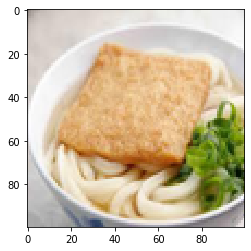

In [82]:
plt.imshow(x_valid[9])
print("讃岐である確率","/","その他のうどんである確率")
print(udon_rate[9])

## testデータのうどんを確認
- 画像ファイルの読み込みから、加工、モデルを使っての結果表示までを行う関数Image_processingを作成する
- 以下の画像の確認を行う

|番号||
|-|-|
|1|その他のうどん|
|2|讃岐うどん|
|3|チェーン店の讃岐風うどん１|
|4|チェーン店の讃岐風うどん2|
|5|チェーン店の讃岐風うどん3|

In [84]:
def Image_processing(filename):
    img = Image.open(filename)
    test_img = img.convert("RGB").resize((100,100))
    test_udon= np.array(test_img)
    test_udon = test_udon.reshape(-1,100, 100, 3)
    test_udon  = test_udon.astype('float32')
    test_udon /=255
    x_test = test_udon
    zy_test = model.predict(x_test)
    return zy_test,test_img

### １その他のうどん
- 関数を使い、まずはその他のうどんを、きちんとその他のうどんで識別できているか確認
- 86%の確率でその他のうどんと、はっきりと回答
- かまぼこは、讃岐うどんは少なく、麺や、器の大きさが特徴で、讃岐ではないと識別をしやすかったのかもしれない

本場讃岐うどんである確率 0.08 %
その他のうどんである確率 0.86 %


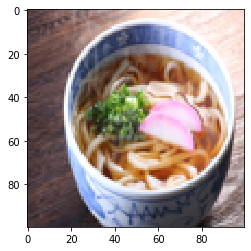

In [86]:
filename = "test/another.jpg"

plt.imshow(Image_processing(filename)[1])
print("本場讃岐うどんである確率",round(Image_processing(filename)[0][0,0],2),"%")
print("その他のうどんである確率",round(Image_processing(filename)[0][0,1],2),"%")

### 2　本場讃岐うどん

- 98%の確率ではっきりと讃岐うどんと識別
- 麺の特徴を掴んだのかもしれない、器があまり写っていないので、他の余計な特徴がないので、識別しやすかったのかもしれない

本場讃岐うどんである確率 0.98 %
その他のうどんである確率 0.01 %


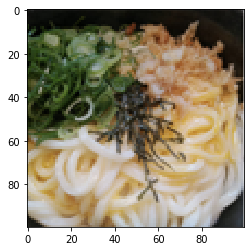

In [88]:
filename = "test/sanuki.jpg"

plt.imshow(Image_processing(filename)[1])
print("本場讃岐うどんである確率",round(Image_processing(filename)[0][0,0],2),"%")
print("その他のうどんである確率",round(Image_processing(filename)[0][0,1],2),"%")

### 3 チェーン店の讃岐風うどん１
- 97%の確率で、讃岐とはっきりとした結果が
- 麺の特徴や載っている具材も、本場讃岐に良くある具材なので、讃岐うどんと識別したのかもしれない

本場讃岐うどんである確率 0.97 %
その他のうどんである確率 0.02 %


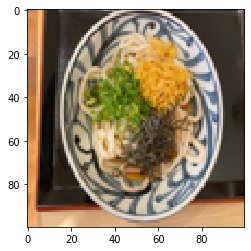

In [90]:
filename = "test/1.jpg"

plt.imshow(Image_processing(filename)[1])
print("本場讃岐うどんである確率",round(Image_processing(filename)[0][0,0],2),"%")
print("その他のうどんである確率",round(Image_processing(filename)[0][0,1],2),"%")

### 4チェーン店の讃岐風うどん
- 99%の確率で、讃岐とはっきりとした結果が
- 麺の特徴や丼も、本場讃岐に多い丼だったのかもしれない

本場讃岐うどんである確率 0.99 %
その他のうどんである確率 0.0 %


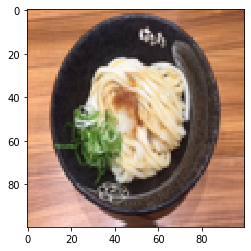

In [92]:
filename = "test/2.JPG"

plt.imshow(Image_processing(filename)[1])
print("本場讃岐うどんである確率",round(Image_processing(filename)[0][0,0],2),"%")
print("その他のうどんである確率",round(Image_processing(filename)[0][0,1],2),"%")

### 5チェーン店の讃岐風うどん
- こちらの、うどんはその他のうどんと識別された。
- 出汁が多いうどんはその他が多いので、それが特徴となったのかもしれない
- また、讃岐うどんの特徴の麺の部分が少なく識別が難しかったのかも入れない
- ただ本場讃岐も３５％なので、少しは讃岐も候補に入っている

本場讃岐うどんである確率 0.33 %
その他のうどんである確率 0.56 %


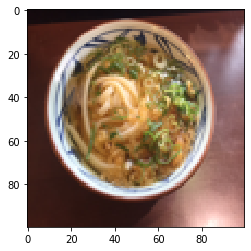

In [93]:
filename = "test/3.JPG"

plt.imshow(Image_processing(filename)[1])
print("本場讃岐うどんである確率",round(Image_processing(filename)[0][0,0],2),"%")
print("その他のうどんである確率",round(Image_processing(filename)[0][0,1],2),"%")

## ■まとめ
- 特徴がはっきりしていれば、９０%以上の確率で答えが返ってくる
- 器や具材など、多少ばらつきがあっても、他に特徴があればほぼ、明確に識別できる

- 油揚げなど、両方ともその特徴があるが、片方の数が少ない場合その特徴が多いラベルに識別される可能性がある
- 対策は検証を繰り返して、学習データを調整するか、最初から特徴を揃えた学習データにするのが良いかもしれない
- 特徴が揃っていると、90%以上の確率ではっきり識別してくるので、特徴が同じ食品の異常を発見するには使えるかもしれない